In [1]:
#Import all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import re
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans

# Set the display format for floating point numbers
pd.options.display.float_format = '{:.2f}'.format

<h3>Load & prepare data for analysis

In [2]:
# Load FULL parking ticket data & StreetCentreline_HundredBlock data

# Specify the path to your Parquet file
file_path = 'parking-tickets.parquet'

# Load the Parquet file into a DataFrame
full_parking_tickets = pd.read_parquet(file_path)

# Display the DataFrame
print(full_parking_tickets)

# Load street data
street_data_filepath = 'StreetCentreline_HundredBlock.xlsx'
street_data = pd.read_excel(street_data_filepath)

         block        street   entrydate  bylaw      section status  \
0         2000    W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
1         2000    W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
2         5900     EAST BLVD  2020-01-04   2849         21.1     IS   
3          400    W 64TH AVE  2020-01-04   2849      17.6(B)     IS   
4          500     ABBOTT ST  2020-01-04   2849         21.1     IS   
...        ...           ...         ...    ...          ...    ...   
1803275    100  NATIONAL AVE  2024-01-31   2849      17.6(E)     IS   
1803276    600    W 14TH AVE  2022-02-10   2849      17.6(B)     IS   
1803277   1100    E 11TH AVE  2022-03-09   2849  17.5(C)(ii)     IS   
1803278    200    E 14TH AVE  2024-05-24   2849      19.1(G)     IS   
1803279   2500       PINE ST  2021-08-31   2952  5(4)(A)(ii)     IS   

                                            infractiontext  year    bi_id  
0        PARK IN A METERED SPACE IF THE PARKING METER H...  2020  36497

In [3]:
#print a sample

print(full_parking_tickets.head(20))
print(full_parking_tickets.shape)
print(street_data.head(20))
print(street_data.shape)

    block            street   entrydate  bylaw      section status  \
0    2000        W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
1    2000        W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
2    5900         EAST BLVD  2020-01-04   2849         21.1     IS   
3     400        W 64TH AVE  2020-01-04   2849      17.6(B)     IS   
4     500         ABBOTT ST  2020-01-04   2849         21.1     IS   
5       0         POWELL ST  2020-01-04   2849      17.2(M)     IS   
6     500        SEYMOUR ST  2020-01-04   2849         21.1     IS   
7     800       RICHARDS ST  2020-01-04   2849      17.6(F)     VA   
8    2200         PARKER ST  2020-01-04   2849      17.6(F)     VA   
9    2600        TRIUMPH ST  2020-01-04   2849      17.6(F)     VA   
10   5800     COMMERCIAL ST  2020-01-04   2849      17.6(F)     VA   
11   4800  PRINCE ALBERT ST  2020-01-04   2849      17.6(F)     VA   
12    800        E 16TH AVE  2020-01-04   2849      17.6(F)     VA   
13   4100      ST GE

In [4]:
# Filter relevant columns from street data
street_data_filtered = street_data[['STREET_NAME', 'LOW_ADDRESS', 'HIGH_ADDRESS', 'NEIGHBORHOOD', 'HBLOCK']]

In [5]:
street_data_filtered.shape

(28115, 5)

<h3>Checking Data Structure and Basic Information:

In [6]:
if full_parking_tickets is not None:
    # Display basic information about the dataframe
    print(full_parking_tickets.info())
    print(full_parking_tickets.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803280 entries, 0 to 1803279
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   block           int64 
 1   street          object
 2   entrydate       object
 3   bylaw           int64 
 4   section         object
 5   status          object
 6   infractiontext  object
 7   year            object
 8   bi_id           int64 
dtypes: int64(3), object(6)
memory usage: 123.8+ MB
None
   block      street   entrydate  bylaw      section status  \
0   2000  W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
1   2000  W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
2   5900   EAST BLVD  2020-01-04   2849         21.1     IS   
3    400  W 64TH AVE  2020-01-04   2849      17.6(B)     IS   
4    500   ABBOTT ST  2020-01-04   2849         21.1     IS   

                                      infractiontext  year    bi_id  
0  PARK IN A METERED SPACE IF THE PARKING METER H...  2020  3649772  
1  P

<h3>Inspecting Numerical Columns

In [7]:
# Describe the numerical columns
full_parking_tickets.describe()

,block,bylaw,bi_id
count,1803280.00,1803280.00,1803280.00
mean,1486.54,2953.11,4590970.65
std,1951.83,673.77,576586.91
min,0.00,2849.00,59169.00
25%,600.00,2849.00,4158522.75
50%,1100.00,2952.00,4610232.50
75%,1900.00,2952.00,5068702.25
max,99900.00,13323.00,5526982.00


<h3>Inspecting Categorical Columns

In [8]:
# Describe the categorical columns
print(full_parking_tickets.describe(include=['object']))

             street   entrydate      section   status  \
count       1803280     1803280      1803280  1803280   
unique          948        1633          125        4   
top     RICHARDS ST  2024-06-12  5(4)(A)(ii)       IS   
freq          88214        1725       678807  1568039   

                                           infractiontext     year  
count                                              847410  1803280  
unique                                                129        5  
top     PARK IN A METERED SPACE IF THE PARKING METER H...     2023  
freq                                               357434   424371  


In [9]:
# Value counts for categorical columns
print(full_parking_tickets['street'].value_counts())
print(full_parking_tickets['entrydate'].value_counts())
print(full_parking_tickets['bylaw'].value_counts())
print(full_parking_tickets['section'].value_counts())
print(full_parking_tickets['status'].value_counts())
print(full_parking_tickets['infractiontext'].value_counts())

RICHARDS ST        88214
HOMER ST           72542
ROBSON ST          61416
W 4TH AVE          56894
W 8TH AVE          47111
                   ...  
SKIPPER PLACE          1
BURKHOLDER DR P        1
ST REGIS LANE          1
KULLAHUN DRIVE         1
SEMANA CRESCENT        1
Name: street, Length: 948, dtype: int64
2024-06-12    1725
2024-06-25    1716
2021-07-07    1691
2024-04-16    1681
2024-06-06    1668
              ... 
2023-08-22      11
2023-08-25      11
2023-08-23      11
2020-01-15       2
2024-01-19       1
Name: entrydate, Length: 1633, dtype: int64
2952     915807
2849     876775
12086      7463
9978       1728
9344        910
13323       597
Name: bylaw, dtype: int64
5(4)(A)(ii)    678807
5(4)(B)        234462
17.6(B)        161747
17.1(B)        158363
17.6(E)         95357
                ...  
8.2(A)(II)          1
17.2(D)             1
8.2(A)(I)           1
17.2(A)             1
8.2(F)              1
Name: section, Length: 125, dtype: int64
IS    1568039
VA     217541

<h3>Check for null values in the data

In [10]:
# Check for null values in tickets data
print(full_parking_tickets.isnull().sum())

block                  0
street                 0
entrydate              0
bylaw                  0
section                0
status                 0
infractiontext    955870
year                   0
bi_id                  0
dtype: int64


<h4>------- Handling missing values:

In [11]:
# filling missing 'InfractionText' values with 'Unknown'
full_parking_tickets['infractiontext'].fillna('Unknown', inplace=True)

# Confirm no missing values remain
null_values_after = full_parking_tickets.isnull().sum()
print("Null values after cleaning:")
print(null_values_after)

Null values after cleaning:
block             0
street            0
entrydate         0
bylaw             0
section           0
status            0
infractiontext    0
year              0
bi_id             0
dtype: int64


<h3>Data Type Conversion:  converting EntryDate column to datetime type.

In [12]:
# Convert 'EntryDate' to datetime
full_parking_tickets['entrydate'] = pd.to_datetime(full_parking_tickets['entrydate'], errors='coerce')
    
# Confirm the data types
print(full_parking_tickets.dtypes)

block                      int64
street                    object
entrydate         datetime64[ns]
bylaw                      int64
section                   object
status                    object
infractiontext            object
year                      object
bi_id                      int64
dtype: object


<h3>Data Quality Check

Perform additional quality checks to ensure the data is clean and ready for analysis.

In [13]:
# Standardize street names in both datasets
street_data_filtered['STREET_NAME'] = street_data_filtered['STREET_NAME'].str.upper().str.strip()
full_parking_tickets['street'] = full_parking_tickets['street'].str.upper().str.strip()

C:\Users\12366\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
# Check for the number of duplicate rows
duplicate_rows = full_parking_tickets.duplicated()
num_duplicates = duplicate_rows.sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Remove duplicate entries if any
full_parking_tickets.drop_duplicates(inplace=True)

Number of duplicate rows: 0


In [15]:
# Check for any remaining inconsistencies or anomalies
print("Data quality checks:")
print(full_parking_tickets.describe(include='all'))

Data quality checks:
            block       street            entrydate      bylaw      section  \
count  1803280.00      1803280              1803280 1803280.00      1803280   
unique        nan          948                 1633        nan          125   
top           nan  RICHARDS ST  2024-06-12 00:00:00        nan  5(4)(A)(ii)   
freq          nan        88214                 1725        nan       678807   
first         nan          NaN  2020-01-02 00:00:00        nan          NaN   
last          nan          NaN  2024-06-30 00:00:00        nan          NaN   
mean      1486.54          NaN                  NaN    2953.11          NaN   
std       1951.83          NaN                  NaN     673.77          NaN   
min          0.00          NaN                  NaN    2849.00          NaN   
25%        600.00          NaN                  NaN    2849.00          NaN   
50%       1100.00          NaN                  NaN    2952.00          NaN   
75%       1900.00          NaN 

<h2>Data Loading & Cleaning Combined

In [16]:
# Specify the path to your Parquet file
file_path = 'parking-tickets.parquet'

# Load the Parquet file into a DataFrame
full_parking_tickets = pd.read_parquet(file_path)

parking_tickets = full_parking_tickets

# Check data structure and basic information
if parking_tickets is not None:
    print(parking_tickets.info())
    print(parking_tickets.head())

    # Check for null values
    null_values = parking_tickets.isnull().sum()
    print("Null values in each column:")
    print(null_values)

    # Handle missing values
    parking_tickets['infractiontext'].fillna('Unknown', inplace=True)

    # Confirm no missing values remain
    null_values_after = parking_tickets.isnull().sum()
    print("Null values after cleaning:")
    print(null_values_after)

    # Convert 'EntryDate' to datetime
    parking_tickets['entrydate'] = pd.to_datetime(parking_tickets['entrydate'], errors='coerce')
    
    # Confirm the data types
    print(parking_tickets.dtypes)

    # Check for the number of duplicate rows
    duplicate_rows = parking_tickets.duplicated()
    num_duplicates = duplicate_rows.sum()
    print(f"Number of duplicate rows: {num_duplicates}")

    # Remove duplicate entries if any
    parking_tickets.drop_duplicates(inplace=True)
    
    # Check for any remaining inconsistencies or anomalies
    print("Data quality checks:")
    print(parking_tickets.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803280 entries, 0 to 1803279
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   block           int64 
 1   street          object
 2   entrydate       object
 3   bylaw           int64 
 4   section         object
 5   status          object
 6   infractiontext  object
 7   year            object
 8   bi_id           int64 
dtypes: int64(3), object(6)
memory usage: 123.8+ MB
None
   block      street   entrydate  bylaw      section status  \
0   2000  W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
1   2000  W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
2   5900   EAST BLVD  2020-01-04   2849         21.1     IS   
3    400  W 64TH AVE  2020-01-04   2849      17.6(B)     IS   
4    500   ABBOTT ST  2020-01-04   2849         21.1     IS   

                                      infractiontext  year    bi_id  
0  PARK IN A METERED SPACE IF THE PARKING METER H...  2020  3649772  
1  P

<h2>Q.1 Please answer the following questions and provide representative data visualizations where applicable.

<i><b> <h3>a) How many unique hundred-blocks was the rule “Stopping at a place where a traffic sign prohibits stopping” enforced July 2023?

In [17]:
# Define the specific infraction and the month/year for filtering
specific_infraction = 'STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS STOPPING'
month = 7
year = 2023

# Filter data for the specific month and year
specific_date_data = full_parking_tickets[
    (full_parking_tickets['entrydate'].dt.month == month) &
    (full_parking_tickets['entrydate'].dt.year == year) &
    (full_parking_tickets['infractiontext'] == specific_infraction)
]

# Create a new column for just the date part (remove the time part)
specific_date_data['EntryDateOnly'] = specific_date_data['entrydate'].dt.date


C:\Users\12366\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
specific_date_data.shape

(4806, 10)

In [19]:
# Count unique hundred-blocks for a specific infraction in July 2023
unique_blocks = specific_date_data[specific_date_data['infractiontext'] == specific_infraction]['block'].nunique()

print(f"Unique hundred-blocks for '{specific_infraction}' in July 2023: {unique_blocks}")

Unique hundred-blocks for 'STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS STOPPING' in July 2023: 78


<i><b> <h3>b) Can you provide a heat map of “Stopping at a place where a traffic sign prohibits stopping” parking tickets across the City in July 2023?

C:\Users\12366\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


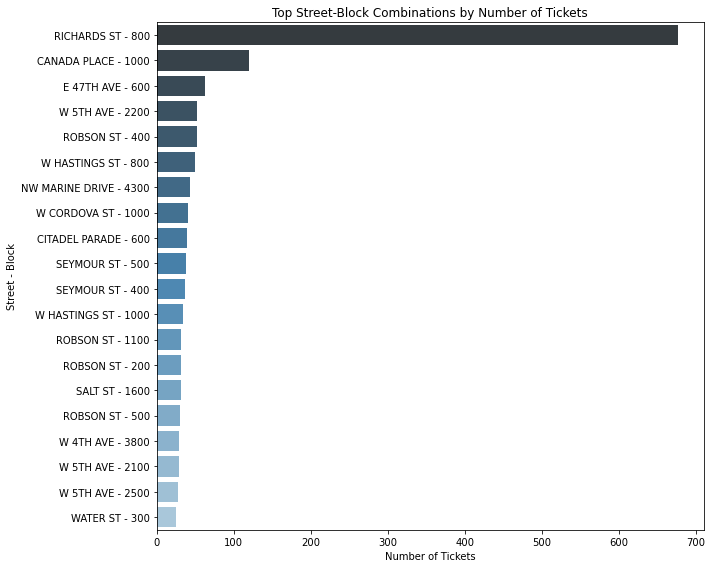

In [20]:
# Combine Street and Block into a single column
specific_date_data['Street_Block'] = specific_date_data['street'] + ' - ' + specific_date_data['block'].astype(str)

# Calculate the number of tickets for each street-block combination
ticket_counts = specific_date_data[specific_date_data['infractiontext'] == specific_infraction].groupby('Street_Block').size().reset_index(name='Number of Tickets')

# Sort the data to get the top ticketed street-block combinations
top_ticket_counts = ticket_counts.sort_values(by='Number of Tickets', ascending=False).head(20)

# Create a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(data=top_ticket_counts, x='Number of Tickets', y='Street_Block', palette='Blues_d')
plt.title('Top Street-Block Combinations by Number of Tickets')
plt.xlabel('Number of Tickets')
plt.ylabel('Street - Block')
plt.tight_layout()
plt.show()


C:\Users\12366\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Top street-block combinations with the highest number of tickets in July 2023:
           Street_Block EntryDateOnly  Number of Tickets
2204   W 5TH AVE - 2200    2023-07-08                 52
1515  RICHARDS ST - 800    2023-07-26                 36
1495  RICHARDS ST - 800    2023-07-06                 31
2203   W 5TH AVE - 2100    2023-07-08                 29
1514  RICHARDS ST - 800    2023-07-25                 28
2209   W 5TH AVE - 2500    2023-07-08                 28
1507  RICHARDS ST - 800    2023-07-18                 28
1508  RICHARDS ST - 800    2023-07-19                 28
1494  RICHARDS ST - 800    2023-07-05                 28
1493  RICHARDS ST - 800    2023-07-04                 26


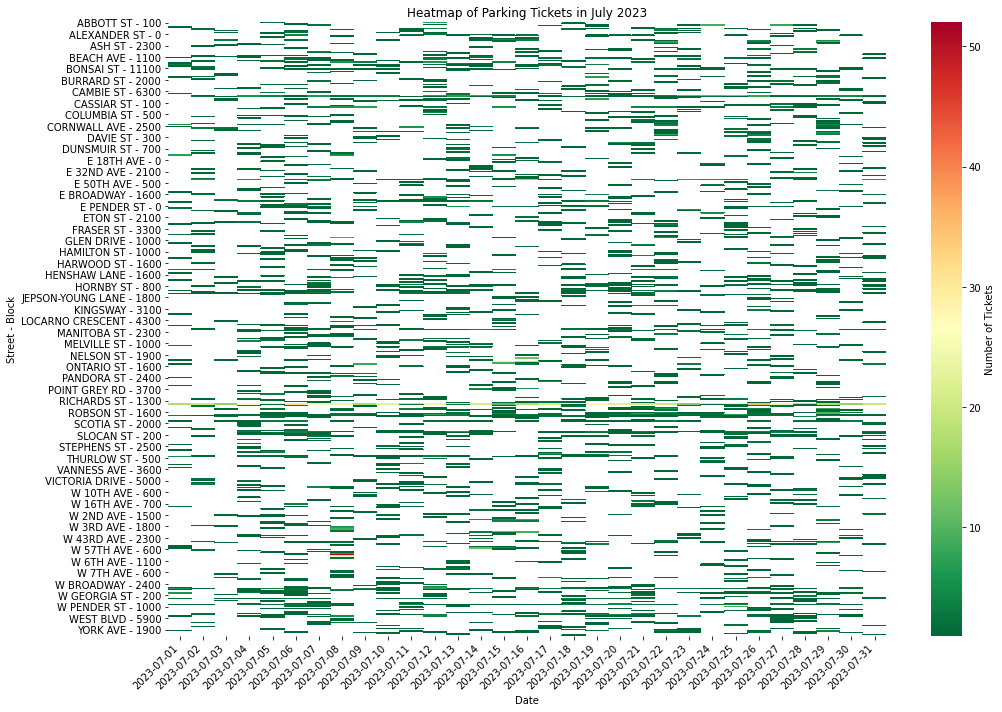

In [21]:
# Combine Street and Block into a single column
specific_date_data['Street_Block'] = specific_date_data['street'] + ' - ' + specific_date_data['block'].astype(str)

# Calculate the number of tickets for each street-block combination on each date
ticket_counts = specific_date_data[specific_date_data['infractiontext'] == specific_infraction].groupby(['Street_Block', 'EntryDateOnly']).size().reset_index(name='Number of Tickets')

# Find the street-block combinations with the highest number of tickets
top_ticket_counts = ticket_counts.sort_values(by='Number of Tickets', ascending=False).head(10)

print("Top street-block combinations with the highest number of tickets in July 2023:")
print(top_ticket_counts)

# Heatmap of parking tickets
plt.figure(figsize=(15, 10))
heatmap_data = pd.pivot_table(specific_date_data[specific_date_data['infractiontext'] == specific_infraction], values='bi_id', index='Street_Block', columns='EntryDateOnly', aggfunc='count')

# Define the colormap
colors = sns.color_palette("RdYlGn_r", 256)
cmap = ListedColormap(colors)

sns.heatmap(heatmap_data, cmap=cmap, cbar_kws={'label': 'Number of Tickets'})
plt.title('Heatmap of Parking Tickets in July 2023')
plt.xlabel('Date')
plt.ylabel('Street - Block')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<i><b><h3> c) How does this change month by month since the beginning of 2020?

C:\Users\12366\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


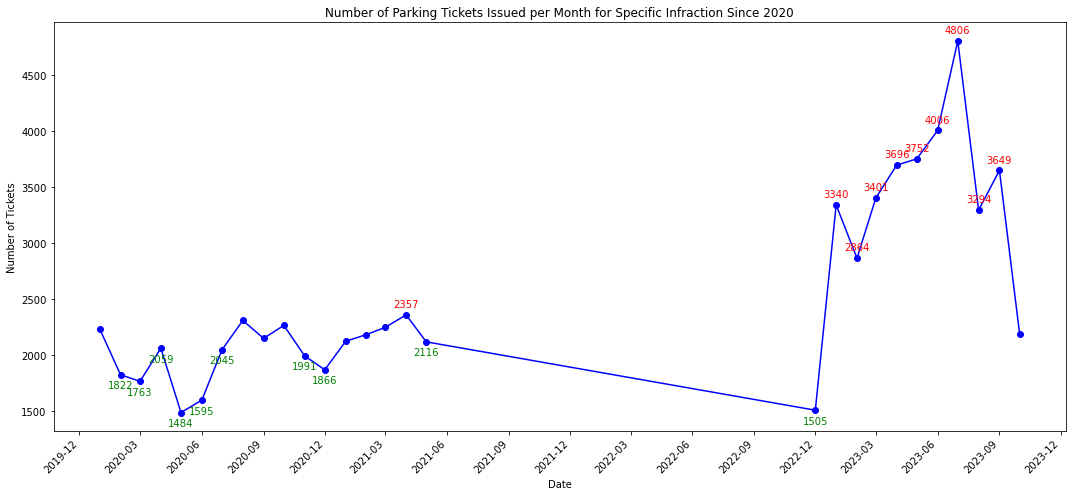

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Assuming full_parking_tickets has been loaded and cleaned as shown previously

# Define the specific infraction
specific_infraction = 'STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS STOPPING'

# Filter data for the specific infraction and from the beginning of 2020
start_date = '2020-01-01'
specific_date_data = full_parking_tickets[
    (full_parking_tickets['entrydate'] >= pd.to_datetime(start_date)) &
    (full_parking_tickets['infractiontext'] == specific_infraction)
]

# Extract year and month from EntryDate
specific_date_data['YearMonth'] = specific_date_data['entrydate'].dt.to_period('M')

# Calculate the number of tickets for each month
monthly_ticket_counts = specific_date_data.groupby('YearMonth').size().reset_index(name='Number of Tickets')

# Convert YearMonth back to datetime for plotting
monthly_ticket_counts['YearMonth'] = monthly_ticket_counts['YearMonth'].dt.to_timestamp()

# Create the line plot
plt.figure(figsize=(15, 7))
plt.plot(monthly_ticket_counts['YearMonth'], monthly_ticket_counts['Number of Tickets'], color='blue', marker='o')

# Find the six highest peaks and six lowest troughs
top_6_high_peaks = monthly_ticket_counts.nlargest(10, 'Number of Tickets')
top_6_low_troughs = monthly_ticket_counts.nsmallest(10, 'Number of Tickets')

# Annotate high peaks
for index, row in top_6_high_peaks.iterrows():
    plt.text(row['YearMonth'], row['Number of Tickets'] + 50, 
             f'{row["Number of Tickets"]}', ha='center', va='bottom', color='red', fontsize=10)

# Annotate low troughs
for index, row in top_6_low_troughs.iterrows():
    plt.text(row['YearMonth'], row['Number of Tickets'] - 50, 
             f'{row["Number of Tickets"]}', ha='center', va='top', color='green', fontsize=10)

# Set quarterly labels on the x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('Number of Parking Tickets Issued per Month for Specific Infraction Since 2020')
plt.xlabel('Date')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


<i><b><h3> d) What was the most frequent type of parking ticket in the Kensington neighborhood in July 2023?

To get the neighbourhood data, we need to merge the two datasets. Lets filter the Parking Ticket data to only include July 2023 data first and then merge the two datasets.

In [23]:
# Define the month/year for filtering
month = 7
year = 2023

# Filter data for the specific month and year
specific_date_data1 = full_parking_tickets[
    (full_parking_tickets['entrydate'].dt.month == month) &
    (full_parking_tickets['entrydate'].dt.year == year)
]

# Create a new column for just the date part (remove the time part)
specific_date_data1['EntryDateOnly'] = specific_date_data1['entrydate'].dt.date

C:\Users\12366\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [24]:
specific_date_data1

,block,street,entrydate,bylaw,section,status,infractiontext,year,bi_id,EntryDateOnly
338,500,W 8TH AVE,2023-07-10,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3650838,2023-07-10
339,500,W 7TH AVE,2023-07-10,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3650841,2023-07-10
340,2300,ASH ST,2023-07-10,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3650843,2023-07-10
341,3000,HEMLOCK ST,2023-07-10,2849,17.2(K),IS,STOP ON ANY STREET OR PORTION OF A STREET DESI...,2023,3650851,2023-07-10
342,3100,GRANVILLE ST,2023-07-10,2849,17.2(K),IS,STOP ON ANY STREET OR PORTION OF A STREET DESI...,2023,3650852,2023-07-10
...,...,...,...,...,...,...,...,...,...,...
1784973,1600,W 3RD AVE,2023-07-28,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3901024,2023-07-28
1784974,1600,W 2ND AVE,2023-07-28,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3901026,2023-07-28
1784975,1700,W 2ND AVE,2023-07-28,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3901027,2023-07-28
1784976,1600,W 4TH AVE,2023-07-28,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3901029,2023-07-28


In [25]:
# Filter relevant columns from street data
street_data_filtered1 = street_data[['STREET_NAME', 'LOW_ADDRESS', 'HIGH_ADDRESS', 'NEIGHBORHOOD', 'HBLOCK']]
street_data_filtered1

,STREET_NAME,LOW_ADDRESS,HIGH_ADDRESS,NEIGHBORHOOD,HBLOCK
0,QUESNEL DRIVE,3700.00,3700.00,Dunbar-Southlands,3700 QUESNEL DRIVE
1,QUESNEL DRIVE,3700.00,3700.00,Dunbar-Southlands,3700 QUESNEL DRIVE
2,GORE AV,900.00,1000.00,Strathcona,900-1000 GORE AV
3,GORE AV,900.00,1000.00,Strathcona,900-1000 GORE AV
4,UNNAMED ST,200.00,300.00,Strathcona,200-300 UNNAMED ST
...,...,...,...,...,...
28110,W 47TH AV,2300.00,2300.00,Kerrisdale,2300 W 47TH AV
28111,VINE ST,6300.00,6400.00,Kerrisdale,6300-6400 VINE ST
28112,VINE ST,6300.00,6400.00,Kerrisdale,6300-6400 VINE ST
28113,BROUGHTON ST,900.00,900.00,West End,900 BROUGHTON ST


In [26]:
# Create a matching column for blocks within the range
def get_hblock(block, low, high):
    if pd.notnull(low) and pd.notnull(high):
        if low <= block <= high:
            return True
    return False

# Apply function to create a match column
specific_date_data1['Match'] = specific_date_data1.apply(
    lambda x: street_data_filtered1[
        (street_data_filtered1['STREET_NAME'] == x['street']) &
        (street_data_filtered1['LOW_ADDRESS'] <= x['block']) &
        (street_data_filtered1['HIGH_ADDRESS'] >= x['block'])
    ].any(axis=None), axis=1
)

C:\Users\12366\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
# Merge datasets
merged_data1 = pd.merge(
    specific_date_data1, street_data_filtered1,
    left_on=['street', 'block'], right_on=['STREET_NAME', 'LOW_ADDRESS'],
    how='left'
)

# Display merged data
merged_data1.head()

,block,street,entrydate,bylaw,section,status,infractiontext,year,bi_id,EntryDateOnly,Match,STREET_NAME,LOW_ADDRESS,HIGH_ADDRESS,NEIGHBORHOOD,HBLOCK
0,500,W 8TH AVE,2023-07-10,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3650838,2023-07-10,False,NaN,nan,nan,NaN,NaN
1,500,W 7TH AVE,2023-07-10,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3650841,2023-07-10,False,NaN,nan,nan,NaN,NaN
2,2300,ASH ST,2023-07-10,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3650843,2023-07-10,True,ASH ST,2300.00,2300.00,Fairview,2300 ASH ST
3,2300,ASH ST,2023-07-10,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3650843,2023-07-10,True,ASH ST,2300.00,2300.00,Fairview,2300 ASH ST
4,2300,ASH ST,2023-07-10,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3650843,2023-07-10,True,ASH ST,2300.00,2300.00,Fairview,2300 ASH ST


In [28]:
#Dealing with duplicated rows:

#Identify duplicated rows
duplicates = merged_data1.duplicated()

#Count the number of duplicated rows
num_duplicates = duplicates.sum()
print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 24847


In [29]:
merged_data1.shape

(64691, 16)

In [30]:
#Drop duplicated rows based on 'BI_ID'
merged_data1 = merged_data1.drop_duplicates(subset='bi_id')

In [31]:
merged_data1.shape

(38842, 16)

In [32]:
# Filter records containing 'Kensington' in the 'NEIGHBORHOOD' column, case insensitive
kensington_tickets = merged_data1[merged_data1['NEIGHBORHOOD'].str.contains('Kensington', case=False, na=False)]
kensington_tickets

,block,street,entrydate,bylaw,section,status,infractiontext,year,bi_id,EntryDateOnly,Match,STREET_NAME,LOW_ADDRESS,HIGH_ADDRESS,NEIGHBORHOOD,HBLOCK
423,4000,PRINCE ALBERT ST,2023-07-10,2849,17.6(B),IS,PARK ON A STREET WHERE A TRAFFIC SIGN RESTRICT...,2023,3655785,2023-07-10,True,PRINCE ALBERT ST,4000.00,4000.00,Kensington-Cedar Cottage,4000 PRINCE ALBERT ST
713,4700,LITTLE ST,2023-07-03,2849,17.2(C),IS,STOP WITHIN 5 METRES OF A FIRE HYDRANT,2023,3656369,2023-07-03,True,LITTLE ST,4700.00,4700.00,Kensington-Cedar Cottage,4700 LITTLE ST
789,4500,GLADSTONE ST,2023-07-13,2849,17.6(B),IS,PARK ON A STREET WHERE A TRAFFIC SIGN RESTRICT...,2023,4092733,2023-07-13,True,GLADSTONE ST,4500.00,4500.00,Kensington-Cedar Cottage,4500 GLADSTONE ST
875,3100,VICTORIA DRIVE,2023-07-13,2849,17.6(F),VA,PARK ON A STREET ABUTTING RESIDENTIAL OR COMME...,2023,4092902,2023-07-13,True,VICTORIA DRIVE,3100.00,3100.00,Kensington-Cedar Cottage,3100 VICTORIA DRIVE
913,3900,KNIGHT ST,2023-07-13,2849,17.2(K),IS,STOP ON ANY STREET OR PORTION OF A STREET DESI...,2023,4092962,2023-07-13,True,KNIGHT ST,3900.00,3900.00,Kensington-Cedar Cottage,3900 KNIGHT ST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63807,3200,FRASER ST,2023-07-20,2849,17.3,IS,STOP ON ANY PORTION OF A STREET DESIGNATED AS ...,2023,3699625,2023-07-20,True,FRASER ST,3200.00,3200.00,Kensington-Cedar Cottage,3200 FRASER ST
64000,2600,COMMERCIAL DRIVE,2023-07-20,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3699991,2023-07-20,True,COMMERCIAL DRIVE,2600.00,2600.00,Kensington-Cedar Cottage,2600 COMMERCIAL DRIVE
64004,2600,COMMERCIAL DRIVE,2023-07-20,2952,5(4)(A)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2023,3699992,2023-07-20,True,COMMERCIAL DRIVE,2600.00,2600.00,Kensington-Cedar Cottage,2600 COMMERCIAL DRIVE
64043,3200,VICTORIA DRIVE,2023-07-20,2849,17.6(B),IS,PARK ON A STREET WHERE A TRAFFIC SIGN RESTRICT...,2023,3700054,2023-07-20,True,VICTORIA DRIVE,3200.00,3300.00,Kensington-Cedar Cottage,3200-3300 VICTORIA DRIVE


In [33]:
# Determine the most frequent ticket type
most_frequent_ticket = kensington_tickets['infractiontext'].value_counts().idxmax()

# Display the result
print(f"The most frequent type of parking ticket in the Kensington neighborhood in July 2023 was: {most_frequent_ticket}")

The most frequent type of parking ticket in the Kensington neighborhood in July 2023 was: STOP ON ANY STREET OR PORTION OF A STREET DESIGNATED AS A PRIORITY CONGESTION MANAGEMENT ROADWAY DURING THE TIME STOPPING IS PROHIBITED


C:\Users\12366\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


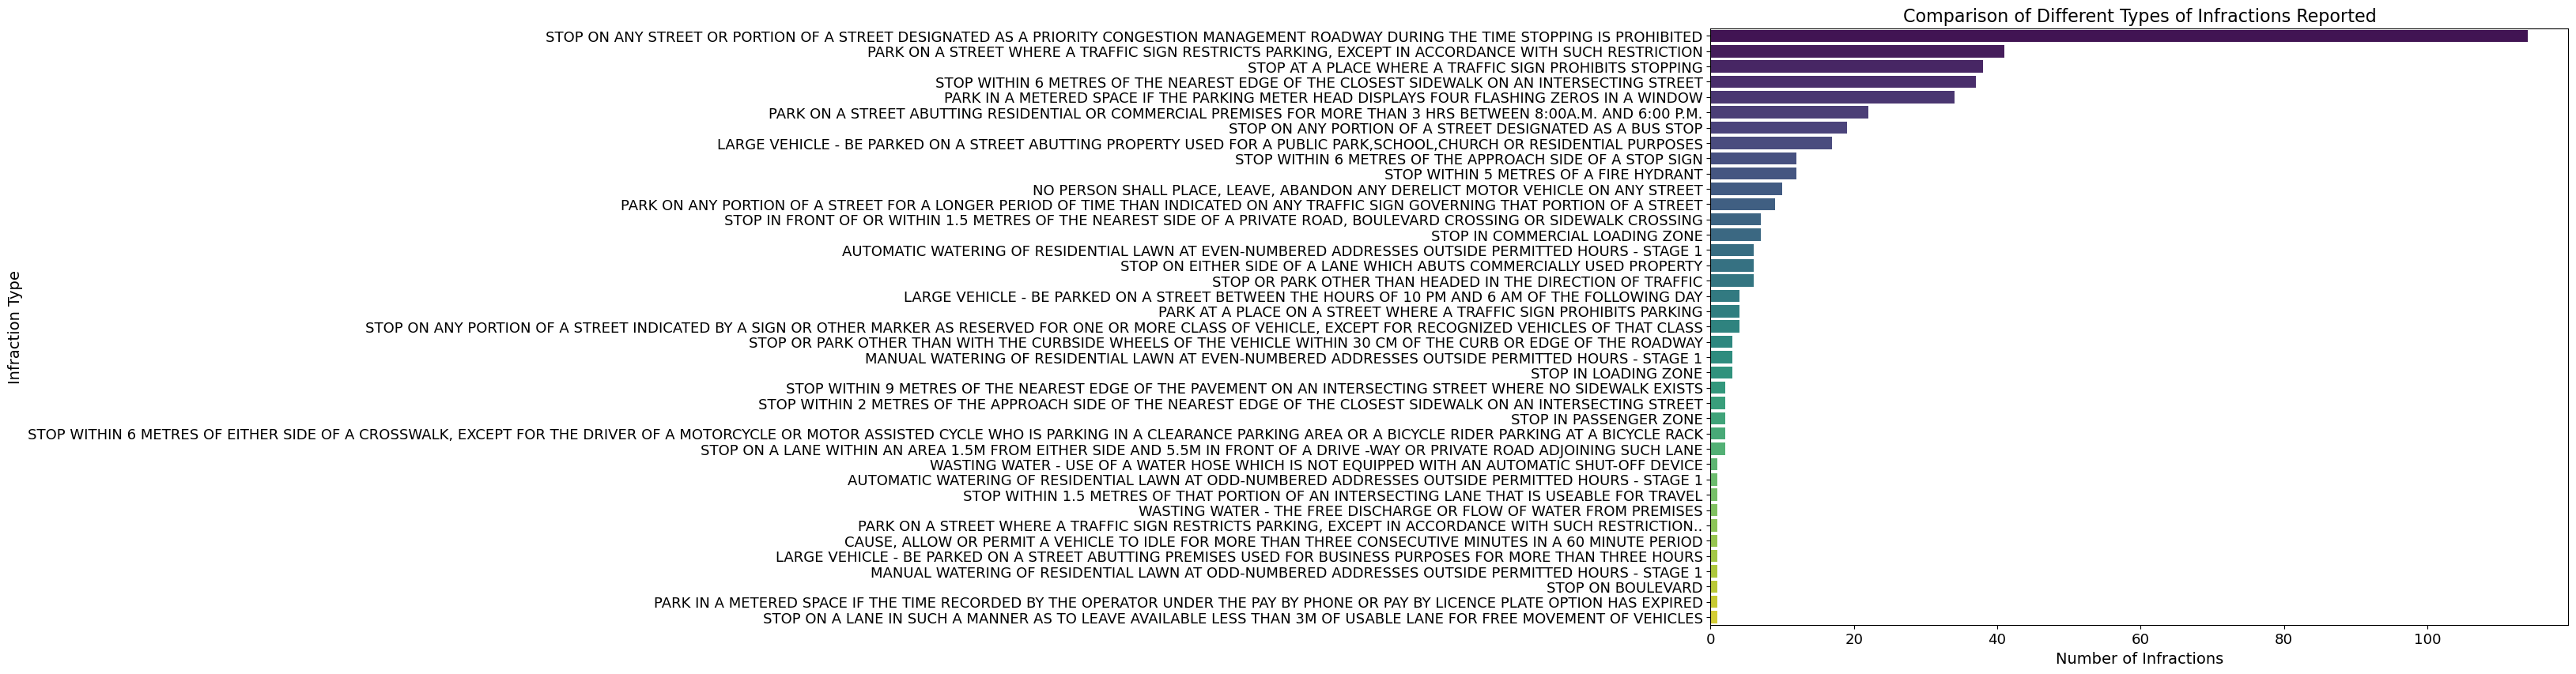

In [34]:
# Aggregate data
infraction_counts = kensington_tickets['infractiontext'].value_counts()

# Create a DataFrame for plotting
infraction_df = infraction_counts.reset_index()
infraction_df.columns = ['Infraction', 'Count']

# Plotting

plt.figure(figsize=(14, 10), dpi=100)  # Increase the figure size and resolution
sns.barplot(x='Count', y='Infraction', data=infraction_df, palette='viridis')
plt.title('Comparison of Different Types of Infractions Reported', fontsize=16)
plt.xlabel('Number of Infractions', fontsize=14)
plt.ylabel('Infraction Type', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()  # Adjust layout to make sure everything fits well
plt.show()

<h2>Q.2 The supervisor mentioned that they spend ~1 hr / week summarizing this data and would like to automate it. Please provide python code that would allow you to automate this report. Show all your steps and results including data loading, cleaning, analysis

<h3>Data Loading, Cleaning & Analysis:

<h2>Data Loading & Cleaning Combined

In [35]:
# Specify the path to your Parquet file
file_path = 'parking-tickets.parquet'

# Load the Parquet file into a DataFrame
full_parking_tickets = pd.read_parquet(file_path)

parking_tickets = full_parking_tickets

# Check data structure and basic information
if parking_tickets is not None:
    print(parking_tickets.info())
    print(parking_tickets.head())

    # Check for null values
    null_values = parking_tickets.isnull().sum()
    print("Null values in each column:")
    print(null_values)

    # Handle missing values
    parking_tickets['infractiontext'].fillna('Unknown', inplace=True)

    # Confirm no missing values remain
    null_values_after = parking_tickets.isnull().sum()
    print("Null values after cleaning:")
    print(null_values_after)

    # Convert 'EntryDate' to datetime
    parking_tickets['entrydate'] = pd.to_datetime(parking_tickets['entrydate'], errors='coerce')
    
    # Confirm the data types
    print(parking_tickets.dtypes)

    # Check for the number of duplicate rows
    duplicate_rows = parking_tickets.duplicated()
    num_duplicates = duplicate_rows.sum()
    print(f"Number of duplicate rows: {num_duplicates}")

    # Remove duplicate entries if any
    parking_tickets.drop_duplicates(inplace=True)
    
    # Check for any remaining inconsistencies or anomalies
    print("Data quality checks:")
    print(parking_tickets.describe(include='all'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803280 entries, 0 to 1803279
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   block           int64 
 1   street          object
 2   entrydate       object
 3   bylaw           int64 
 4   section         object
 5   status          object
 6   infractiontext  object
 7   year            object
 8   bi_id           int64 
dtypes: int64(3), object(6)
memory usage: 123.8+ MB
None
   block      street   entrydate  bylaw      section status  \
0   2000  W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
1   2000  W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
2   5900   EAST BLVD  2020-01-04   2849         21.1     IS   
3    400  W 64TH AVE  2020-01-04   2849      17.6(B)     IS   
4    500   ABBOTT ST  2020-01-04   2849         21.1     IS   

                                      infractiontext  year    bi_id  
0  PARK IN A METERED SPACE IF THE PARKING METER H...  2020  3649772  
1  P

<h2>Q3. Please include a short discussion (max 2 paragraphs)



<h3>a) How would you go about building a forecast of where enforcement is needed?

Building a forecast of where enforcement is needed involves analyzing historical data to identify trends and patterns in parking violations. By examining the frequency and location of past violations, we can predict future hotspots. Machine learning models, such as time series forecasting or spatial analysis, can be employed to make these predictions more accurate. Factors such as time of day, day of the week, weather conditions, and special events should be considered in the analysis.

Additionally, including external data such as traffic flow, construction schedules, and public transit availability can enhance the forecast's accuracy. For instance, areas with high traffic congestion or limited public transit options might require more enforcement. Using a combination of historical data and real-time data analytics, we can create a dynamic and responsive enforcement strategy that adapts to changing conditions and effectively allocates resources to areas with the highest need.

<h3> b) What additional data would you include in the report to facilitate more meaningful insights?

To facilitate more meaningful insights, I would include additional data that could impact parking patterns and enforcement needs. This data would enhance the analysis and help in making more informed decisions:

   <b> Traffic Flow Data:</b>
        Information on traffic volume and flow can provide insights into areas with high vehicle congestion, which might correlate with higher parking violations.

   <b>Special Events Calendar:</b>
        Data on special events (e.g., concerts, sports events, festivals) can help predict temporary spikes in parking violations around event locations.

   <b>Weather Data:</b>
        Weather conditions can influence parking behavior. For instance, people might park illegally to avoid walking long distances in bad weather.

   <b>Demographic Data:</b>
        Demographic information, such as population density and the presence of commercial or residential areas, can provide context on why certain areas experience more violations.

   <b>Public Transit Data:</b>
        Availability and proximity of public transit options might affect parking patterns. Areas with limited public transit might see more parking infractions as people rely more on personal vehicles.

   <b>Construction and Roadwork Schedules:</b>
        Information on ongoing or planned construction projects can help predict temporary changes in parking availability and potential increases in violations in nearby areas.

By incorporating these additional datasets, the analysis would provide a more comprehensive understanding of parking patterns and enforcement needs, leading to more effective and targeted enforcement strategies.

<h2>Additional Analysis:

<h4>Bar Plot for number of tickets for a specific infraction for the specific time period

C:\Users\12366\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


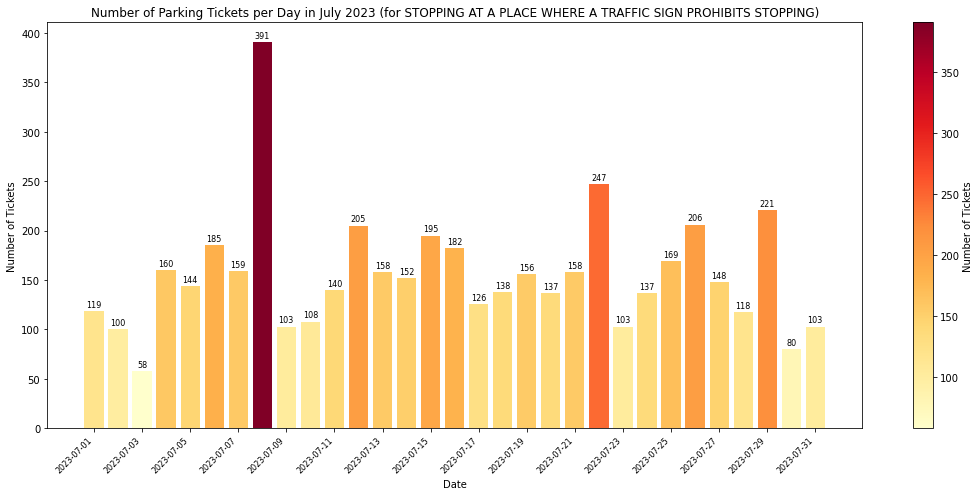

In [36]:
# Define the specific infraction and the month/year for filtering
specific_infraction = 'STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS STOPPING'
month = 7
year = 2023

# Filter data for the specific month and year
specific_date_data = full_parking_tickets[
    (full_parking_tickets['entrydate'].dt.month == month) &
    (full_parking_tickets['entrydate'].dt.year == year) &
    (full_parking_tickets['infractiontext'] == specific_infraction)
]

# Create a new column for just the date part (remove the time part)
specific_date_data['EntryDateOnly'] = specific_date_data['entrydate'].dt.date


# Calculate the number of tickets for each date
ticket_counts = specific_date_data.groupby('EntryDateOnly').size().reset_index(name='Number of Tickets')

# Normalize the number of tickets for color mapping
norm = plt.Normalize(ticket_counts['Number of Tickets'].min(), ticket_counts['Number of Tickets'].max())
cmap = plt.get_cmap('YlOrRd')

# Create the bar plot with gradient colors
plt.figure(figsize=(15, 7))
bar_colors = cmap(norm(ticket_counts['Number of Tickets']))
bars = plt.bar(ticket_counts['EntryDateOnly'], ticket_counts['Number of Tickets'], color=bar_colors)

# Add annotations for the number of tickets above each bar with smaller font size and better spacing
for i in range(len(ticket_counts)):
    plt.text(ticket_counts['EntryDateOnly'][i], ticket_counts['Number of Tickets'][i] + 2, 
             str(ticket_counts['Number of Tickets'][i]), ha='center', va='bottom', fontsize=8)

plt.title('Number of Parking Tickets per Day in July 2023 (for STOPPING AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS STOPPING)')
plt.xlabel('Date')
plt.ylabel('Number of Tickets')

# Reduce the number of x-axis labels by setting an interval
plt.xticks(ticket_counts['EntryDateOnly'][::2], rotation=45, ha='right', fontsize=8)

plt.tight_layout()

# Adding a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Number of Tickets')

plt.show()

<h2>Cluster Analysis:

Streets in Cluster 0:
['ABBOTT ST', 'ALBERNI ST', 'ALEXANDER ST', 'BEACH AVE', 'BEATTY ST', 'BIDWELL ST', 'BONSAI ST', 'BURNABY ST', 'BURRARD ST', 'CAMBIE ST', 'CARDERO ST', 'CITADEL PARADE', 'COMMERCIAL DRIVE', 'CORNWALL AVE', 'DAVIE ST', 'DENMAN ST', 'E 13TH AVE', 'E HASTINGS ST', 'E PENDER ST', 'FIR ST', 'FRASER ST', 'GARDEN DRIVE', 'GRANVILLE ST', 'HAMILTON ST', 'HELMCKEN ST', 'HOMER ST', 'HORNBY ST', 'KINGSWAY', 'MAIN ST', 'MAINLAND ST', 'MAPLE ST', 'MARINASIDE CRESCENT', 'MOBERLY RD', 'NELSON ST', 'PENDRELL ST', 'POINT GREY RD', 'RIVER DISTRICT CROSSING', 'SALT ST', 'SMITHE ST', 'THURLOW ST', 'VICTORIA DRIVE', 'W 1ST AVE', 'W 2ND AVE', 'W 8TH AVE', 'W GEORGIA ST', 'W PENDER ST', 'WATER ST', 'YEW ST', 'YORK AVE']

Streets in Cluster 1:
['RICHARDS ST']

Streets in Cluster 2:
['ABERDEEN ST', 'ADANAC ST', 'ALDER ST', 'ALMA ST', 'ASH ST', 'ATHLETES WAY', 'BAILLIE ST', 'BALACLAVA ST', 'BALSAM ST', 'BARCLAY ST', 'BAYSHORE DR', 'BEACH CRESCENT', 'BELMONT AVE', 'BERKELEY ST', 'BLENHEIM ST

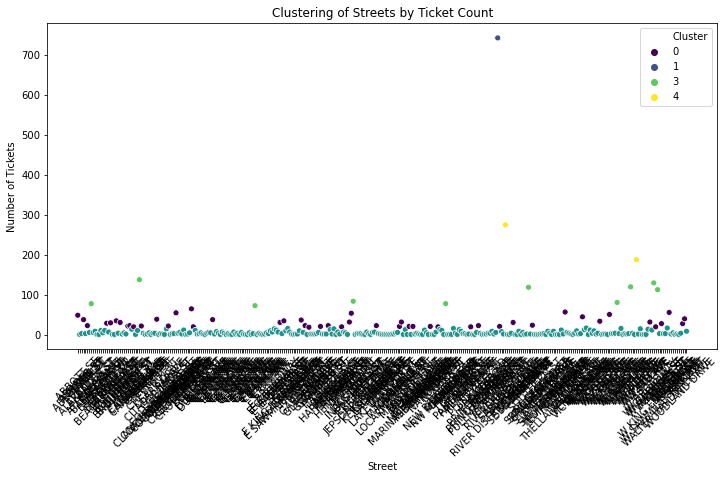

In [37]:
# Function to perform clustering
def perform_clustering(specific_date_data):
    # Prepare data for clustering
    street_grouped = specific_date_data.groupby('street').size().reset_index(name='TicketCount')

    # Run KMeans clustering
    kmeans = KMeans(n_clusters=5, random_state=0).fit(street_grouped[['TicketCount']])

    # Add cluster labels to the dataframe
    street_grouped['Cluster'] = kmeans.labels_

    # Print out the streets in each cluster
    for cluster_num in range(5):
        print(f"Streets in Cluster {cluster_num}:")
        streets_in_cluster = street_grouped[street_grouped['Cluster'] == cluster_num]['street']
        print(streets_in_cluster.tolist())
        print()
    
    # Visualize the clusters
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=street_grouped, x='street', y='TicketCount', hue='Cluster', palette='viridis')
    plt.title('Clustering of Streets by Ticket Count')
    plt.xlabel('Street')
    plt.ylabel('Number of Tickets')
    plt.xticks(rotation=45)
    plt.show()
    
if parking_tickets is not None:
    perform_clustering(specific_date_data)

<h2>Geomapping the Parking Tickets Data (July 2023) by merging with 'Street Trees' Data (for Latitude & Longitude info): 

https://opendata.vancouver.ca/explore/dataset/street-trees/information/?disjunctive.species_name&disjunctive.common_name&disjunctive.on_street&disjunctive.neighbourhood_name

In [38]:
 # Load data
street_trees_data = pd.read_csv('street-trees.csv', delimiter=';', encoding='utf-8', error_bad_lines=False)
street_trees_data.head(10)

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ASSIGNED,ROOT_BARRIER,PLANT_AREA,...,ON_STREET,NEIGHBOURHOOD_NAME,STREET_SIDE_NAME,HEIGHT_RANGE_ID,HEIGHT_RANGE,DIAMETER,CURB,DATE_PLANTED,Geom,geo_point_2d
0,96658,1864,MATTHEWS AV,BETULA,PENDULA,NaN,EUROPEAN WHITE BIRCH,N,N,8,...,PINE CRESCENT,SHAUGHNESSY,ODD,5,50' - 60',17.00,Y,NaN,"{""coordinates"": [-123.147427, 49.250793], ""typ...","49.250793, -123.147427"
1,96663,1902,MATTHEWS AV,PRUNUS,SARGENTII,RANCHO,RANCHO SARGENT CHERRY,N,N,8,...,MATTHEWS AV,SHAUGHNESSY,EVEN,2,20' - 30',10.00,Y,NaN,"{""coordinates"": [-123.149101, 49.251123], ""typ...","49.251123, -123.149101"
2,96664,1902,MATTHEWS AV,PRUNUS,CERASIFERA,ATROPURPUREA,PISSARD PLUM,N,N,8,...,MATTHEWS AV,SHAUGHNESSY,EVEN,2,20' - 30',10.00,Y,NaN,"{""coordinates"": [-123.149295, 49.251156], ""typ...","49.251156, -123.149295"
3,96671,1950,MATTHEWS AV,PRUNUS,CERASIFERA,ATROPURPUREA,PISSARD PLUM,N,N,8,...,MATTHEWS AV,SHAUGHNESSY,EVEN,2,20' - 30',10.50,Y,NaN,"{""coordinates"": [-123.14987, 49.25131], ""type""...","49.25131, -123.14987"
4,96672,1955,MATTHEWS AV,ULMUS,AMERICANA,NaN,AMERICAN ELM,N,N,8,...,MATTHEWS AV,SHAUGHNESSY,ODD,8,80' - 90',27.50,Y,NaN,"{""coordinates"": [-123.149743, 49.251378], ""typ...","49.251378, -123.149743"
5,96674,1955,MATTHEWS AV,ULMUS,AMERICANA,NaN,AMERICAN ELM,N,N,8,...,MATTHEWS AV,SHAUGHNESSY,ODD,7,70' - 80',27.50,Y,NaN,"{""coordinates"": [-123.14945, 49.251291], ""type...","49.251291, -123.14945"
6,96680,1998,MATTHEWS AV,PRUNUS,CERASIFERA,ATROPURPUREA,PISSARD PLUM,N,N,8,...,MATTHEWS AV,SHAUGHNESSY,EVEN,2,20' - 30',11.00,Y,NaN,"{""coordinates"": [-123.150413, 49.25155], ""type...","49.25155, -123.150413"
7,96687,2688,W 39TH AV,AESCULUS,HIPPOCASTANUM,NaN,COMMON HORSECHESTNUT,N,N,7,...,TRAFALGAR ST,ARBUTUS RIDGE,EVEN,4,40' - 50',20.00,Y,NaN,"{""coordinates"": [-123.165726, 49.23632], ""type...","49.23632, -123.165726"
8,96700,3321,MAYFAIR AV,ULMUS,AMERICANA,NaN,AMERICAN ELM,N,N,10,...,MAYFAIR AV,DUNBAR-SOUTHLANDS,ODD,8,80' - 90',42.00,N,NaN,"{""coordinates"": [-123.17913, 49.23694], ""type""...","49.23694, -123.17913"
9,96703,3335,W 39TH AV,CORNUS,NUTTALLII,NaN,PACIFIC DOGWOOD,N,N,N,...,MAYFAIR AV,DUNBAR-SOUTHLANDS,EVEN,3,30' - 40',18.00,N,NaN,"{""coordinates"": [-123.17953, 49.2368], ""type"":...","49.2368, -123.17953"


In [39]:
street_trees_data.shape

(152148, 21)

In [40]:
# Check for duplicated rows
duplicates = street_trees_data.duplicated()

# Print the duplicated rows
print(street_trees_data[duplicates])

# Count the number of duplicated rows
num_duplicated_rows = duplicates.sum()
print(f"Number of duplicated rows: {num_duplicated_rows}")

Empty DataFrame
Columns: [TREE_ID, CIVIC_NUMBER, STD_STREET, GENUS_NAME, SPECIES_NAME, CULTIVAR_NAME, COMMON_NAME, ASSIGNED, ROOT_BARRIER, PLANT_AREA, ON_STREET_BLOCK, ON_STREET, NEIGHBOURHOOD_NAME, STREET_SIDE_NAME, HEIGHT_RANGE_ID, HEIGHT_RANGE, DIAMETER, CURB, DATE_PLANTED, Geom, geo_point_2d]
Index: []

[0 rows x 21 columns]
Number of duplicated rows: 0


In [41]:
#Inspecting for null values

null_street_trees_data = street_trees_data.isnull().sum()
print("Null values in each column:")
print(null_street_trees_data)

Null values in each column:
TREE_ID                   0
CIVIC_NUMBER              0
STD_STREET                0
GENUS_NAME                0
SPECIES_NAME              0
CULTIVAR_NAME         71449
COMMON_NAME               0
ASSIGNED                  0
ROOT_BARRIER              0
PLANT_AREA             1444
ON_STREET_BLOCK           0
ON_STREET                 0
NEIGHBOURHOOD_NAME        0
STREET_SIDE_NAME          0
HEIGHT_RANGE_ID           0
HEIGHT_RANGE              0
DIAMETER                  0
CURB                      0
DATE_PLANTED          78382
Geom                   4210
geo_point_2d           4210
dtype: int64


In [42]:
# Define the specific infraction and the month/year for filtering
specific_infraction = 'STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS STOPPING'
month = 7
year = 2023

# Filter data for the specific month and year
specific_date_data2 = full_parking_tickets[
    (full_parking_tickets['entrydate'].dt.month == month) &
    (full_parking_tickets['entrydate'].dt.year == year) &
    (full_parking_tickets['infractiontext'] == specific_infraction)
]

# Create a new column for just the date part (remove the time part)
specific_date_data2['EntryDateOnly'] = specific_date_data2['entrydate'].dt.date


C:\Users\12366\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
# Standardize street names in both datasets
specific_date_data2['street'] = specific_date_data2['street'].str.upper().str.strip()
street_trees_data['ON_STREET'] = street_trees_data['ON_STREET'].str.upper().str.strip()

C:\Users\12366\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
# Filter relevant columns from street data
street_trees_filtered = street_trees_data[['ON_STREET_BLOCK', 'ON_STREET', 'Geom', 'geo_point_2d']]

In [45]:
# Merge datasets
merged_data2 = pd.merge(
    specific_date_data2, street_trees_filtered,
    left_on=['street', 'block'], right_on=['ON_STREET', 'ON_STREET_BLOCK'],
    how='left'
)

# Display merged data
merged_data2.head()

,block,street,entrydate,bylaw,section,status,infractiontext,year,bi_id,EntryDateOnly,ON_STREET_BLOCK,ON_STREET,Geom,geo_point_2d
0,800,RICHARDS ST,2023-07-10,2849,17.1(B),VA,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2023,3650923,2023-07-10,800.00,RICHARDS ST,"{""coordinates"": [-123.118085, 49.27985], ""type...","49.27985, -123.118085"
1,800,RICHARDS ST,2023-07-10,2849,17.1(B),VA,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2023,3650923,2023-07-10,800.00,RICHARDS ST,"{""coordinates"": [-123.118863, 49.279336], ""typ...","49.279336, -123.118863"
2,800,RICHARDS ST,2023-07-10,2849,17.1(B),VA,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2023,3650923,2023-07-10,800.00,RICHARDS ST,NaN,NaN
3,800,RICHARDS ST,2023-07-10,2849,17.1(B),VA,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2023,3650923,2023-07-10,800.00,RICHARDS ST,"{""coordinates"": [-123.119228, 49.279106], ""typ...","49.279106, -123.119228"
4,800,RICHARDS ST,2023-07-10,2849,17.1(B),VA,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2023,3650923,2023-07-10,800.00,RICHARDS ST,"{""coordinates"": [-123.118106, 49.280025], ""typ...","49.280025, -123.118106"


In [46]:
merged_data2.shape

(60129, 14)

In [47]:
# Check for null values in tickets data
print(merged_data2.isnull().sum())

block                 0
street                0
entrydate             0
bylaw                 0
section               0
status                0
infractiontext        0
year                  0
bi_id                 0
EntryDateOnly         0
ON_STREET_BLOCK    1645
ON_STREET          1645
Geom               6596
geo_point_2d       6596
dtype: int64


In [48]:
# Drop duplicates based on 'BI_ID'
unique_data = merged_data2.drop_duplicates(subset='bi_id')

# View the resulting DataFrame
print(unique_data)

       block            street  entrydate  bylaw  section status  \
0        800       RICHARDS ST 2023-07-10   2849  17.1(B)     VA   
25      1900        W 42ND AVE 2023-07-10   2849  17.1(B)     IS   
26      1700          DAVIE ST 2023-07-10   2849  17.1(B)     IS   
34      1000         DENMAN ST 2023-07-10   2849  17.1(B)     IS   
53       100          DAVIE ST 2023-07-10   2849  17.1(B)     IS   
...      ...               ...        ...    ...      ...    ...   
60041   1600  COMMERCIAL DRIVE 2023-07-28   2849  17.1(B)     IS   
60049   1000     W HASTINGS ST 2023-07-28   2849  17.1(B)     IS   
60083   1000     W HASTINGS ST 2023-07-28   2849  17.1(B)     IS   
60117   4300         WATSON ST 2023-07-28   2849  17.1(B)     IS   
60118   1900         BALSAM ST 2023-07-28   2849  17.1(B)     IS   

                                          infractiontext  year    bi_id  \
0      STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...  2023  3650923   
25     STOP AT A PLACE WHERE A TR

In [49]:
# Check for null values in tickets data
print(unique_data.isnull().sum())

block                 0
street                0
entrydate             0
bylaw                 0
section               0
status                0
infractiontext        0
year                  0
bi_id                 0
EntryDateOnly         0
ON_STREET_BLOCK    1645
ON_STREET          1645
Geom               1839
geo_point_2d       1839
dtype: int64


In [50]:
unique_data.shape

(4806, 14)

In [51]:
# Split the 'geo_point_2d' column into 'Latitude' and 'Longitude' columns
unique_data[['Latitude', 'Longitude']] = unique_data['geo_point_2d'].str.split(', ', expand=True)

C:\Users\12366\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [52]:
# Convert the 'Latitude' and 'Longitude' columns to numeric types
unique_data['Latitude'] = pd.to_numeric(unique_data['Latitude'])
unique_data['Longitude'] = pd.to_numeric(unique_data['Longitude'])

C:\Users\12366\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\12366\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
import folium
from folium.plugins import HeatMap

# Drop rows with missing coordinates
unique_data = unique_data.dropna(subset=['Latitude', 'Longitude'])

# Create a list of coordinates
heat_data = [[row['Latitude'], row['Longitude']] for index, row in unique_data.iterrows()]

# Create a heatmap
map_vancouver = folium.Map(location=[49.2827, -123.1207], zoom_start=12)
HeatMap(heat_data).add_to(map_vancouver)

# Save and display the map
map_vancouver.save('heatmap.html')